In [ ]:
from collections import OrderedDict
import copy
from google.colab import drive
from IPython.display import display
import matplotlib
matplotlib.rcParams['figure.figsize'] = [4, 3]
matplotlib.rcParams['font.size'] = 8
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch import log, manual_seed, nn, ones_like, optim, pow, tensor
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [ ]:
!pip install pylogit

**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [ ]:
import pylogit as pl

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CMAP Dataset

## Data import

In [ ]:
size = 1000
var, alt = 'auto_cost', 0
data1 = pd.read_csv('/content/drive/My Drive/CMAP/data.csv', index_col=0).sample(size, random_state=0)
data1['mode_imputed'] = data1['mode_imputed'].add(-1)

In [ ]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode_imputed'] = data1['mode_imputed']

In [ ]:
train_size = int(size*.7)
data_train, data_test = data[:train_size], data[train_size:]

## Data processing
2. Build a dataframe with mean values, except for the visualized variable,
3. Build a dataframe with the same size for model regularity calculation, and
4. Load the data for training and testing.

In [ ]:
upper, lower = data[var].max(), data[var].min()
data_prb = pd.DataFrame(np.zeros((51, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, len(data_prb))

In [ ]:
data_reg = data_test.copy()
data_reg = data_reg.loc[data_reg.index.repeat(2)]
num_var = data_reg.columns.get_loc(var)
data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 50

In [ ]:
class Load_data(Dataset):
    'Class to load the training, test, and plotting sets'
    def __init__(self, data):
        x_set = data.drop(columns='mode_imputed')
        y_set = data['mode_imputed']
        self.X = Variable(tensor(x_set.values).float(), requires_grad=True)
        self.y = tensor(y_set.values)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

train_loader = DataLoader(Load_data(data_train), batch_size=size//10, shuffle=True)
test_loader = DataLoader(Load_data(data_test), batch_size=len(data_test))

# Datasets for model analysis
share_loader = DataLoader(Load_data(data_train), batch_size=train_size)
prb_loader = DataLoader(Load_data(data_prb), batch_size=len(data_prb))
reg_loader = DataLoader(Load_data(data_reg), batch_size=len(data_reg))

## True market shares

In [ ]:
ls_alt = ['Auto', 'Train', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode_imputed'].replace(0, ls_alt[0]).replace(1, ls_alt[1]).replace(2, ls_alt[2])
    return y.value_counts(normalize=True)

In [ ]:
# Training set
true_share(data_train)

Auto      0.687143
Active    0.197143
Train     0.115714
Name: mode_imputed, dtype: float64

In [ ]:
# Testing set
true_share(data_test)

Auto      0.73
Active    0.17
Train     0.10
Name: mode_imputed, dtype: float64

# Multinomial Logit (MNL)

## Data processing
The MNL model is estimated based on unstandardized inputs and a data frame with wide format.

In [ ]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'train', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:4]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'train_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_train', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode_imputed', 'alt_id')
    return df_lg

In [ ]:
data1_train, data1_test = data1[:train_size], data1[train_size:]
data1_train_lg = convert(data1_train)
data1_train_lg

,obs_id,alt_id,mode_imputed,sex,inc,age,veh,time,cost
0,1,0,0,1,0,40,0,9.216667,6.5078
1,1,1,1,1,0,40,0,32.450000,2.2750
2,1,2,0,1,0,40,0,30.500000,0.0000
3,2,0,1,0,1,55,1,5.883333,7.0628
4,2,1,0,0,1,55,1,37.116667,2.0800
...,...,...,...,...,...,...,...,...,...
2095,699,1,0,1,0,52,2,18.083333,2.4250
2096,699,2,1,1,0,52,2,11.208333,0.0000
2097,700,0,1,0,1,59,4,9.566667,6.6004
2098,700,1,0,0,1,59,4,54.383333,2.5100


## Model structure
The deterministic utilities are specified as follows:

\begin{align}
    V_{n1} &= w_{\mathrm{time},1} \mathrm{time}_{nc} + w_{\mathrm{cost},1} \mathrm{cost}_{n1} \\
    V_{n2} &= w_{0,2} + w_{\mathrm{sex},2} \mathrm{sex}_n + w_{\mathrm{inc},2} \mathrm{inc}_n + w_{\mathrm{age},2} \mathrm{age}_n + w_{\mathrm{veh},2} \mathrm{veh}_n + w_{\mathrm{time},2} \mathrm{time}_{n2} + w_{\mathrm{cost},2} \mathrm{cost}_{n2} \\
    V_{n3} &= w_{0,3} + w_{\mathrm{sex},3} \mathrm{sex}_n + w_{\mathrm{inc},3} \mathrm{inc}_n + w_{\mathrm{age},3} \mathrm{age}_n + w_{\mathrm{veh},3} \mathrm{veh}_n + w_{\mathrm{time},3} \mathrm{time}_{n3}
\end{align}

where subscripts 1-3 represent automobile, train, and the active mode, respectively.

In [ ]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_train', 'asc_active']

# Individual-specific variables
spec['sex'] = [1, 2]
name['sex'] = ['sex_train', 'sex_active']
spec['inc'] = [1, 2]
name['inc'] = ['inc_train', 'inc_active']
spec['age'] = [1, 2]
name['age'] = ['age_train', 'age_active']
spec['veh'] = [1, 2]
name['veh'] = ['veh_train', 'veh_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_train', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_train']

## Parameter estimation

In [ ]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode_imputed',
                             specification=spec, model_type='MNL', names=name)
mnl.fit_mle(np.zeros(15))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -769.0286
Initial Log-likelihood: -769.0286
Estimation Time for Point Estimation: 0.05 seconds.
Final log-likelihood: -478.9174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                mode_imputed   No. Observations:                  700
Model:             Multinomial Logit Model   Df Residuals:                      685
Method:                                MLE   Df Model:                           15
Date:                     Tue, 11 Jul 2023   Pseudo R-squ.:                   0.377
Time:                             06:48:08   Pseudo R-bar-squ.:               0.358
AIC:                               987.835   Log-Likelihood:               -478.917
BIC:                             1,056.101   LL-Null:                      -769.029
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
asc_train      -3.3573      0.962     -3.491      0.000      -5.242      -1.473
asc_active     -1.3153      0.511     -2.574      0.010      -2.317      -0.314
sex_train       0.3319      0.268      1.237      0.216      -0.194       0.858
sex_active      0.6128      0.213      2.883      0.004       0.196       1.029
inc_train       0.5195      0.296      1.754      0.079      -0.061       1.100
inc_active      0.4039      0.233      1.737      0.082      -0.052       0.860
age_train      -0.0099      0.010     -0.944      0.345      -0.030       0.011
age_active     -0.0049      0.008     -0.595      0.552      -0.021       0.011
veh_train      -0.7003      0.179     -3.919      0.000      -1.050      -0.350
veh_active     -0.5761      0.133     -4.331      0.000      -0.837      -0.315
time_auto      -0.0616      0.022     -2.744      0.006      -0.106      -0.018
time_train     -0.0489      0.009     -5.560      0.000      -0.066      -0.032
time_active    -0.0473      0.006     -8.202      0.000      -0.059      -0.036
cost_auto      -0.2291      0.063     -3.622      0.000      -0.353      -0.105
cost_train      0.6270      0.414      1.514      0.130      -0.184       1.439
===============================================================================
"""

## Results

In [ ]:
def mnl_share(df):
    'Function to calculate the MNL market shares'
    pop = len(df)//3
    X = df.drop(columns='mode_imputed')
    prb = sum(mnl.predict(X).reshape(pop, 3)) / pop
    share = pd.DataFrame(prb*100, columns=['Share']).round(decimals=1).astype(str).add('%')
    share.insert(0, 'Mode', ls_alt)
    return share

In [ ]:
# Training set
mnl_share(data1_train_lg)

,Mode,Share
0,Auto,68.7%
1,Train,11.6%
2,Active,19.7%


In [ ]:
# Testing set
data1_test_lg = convert(data1_test)
mnl_share(data1_test_lg)

,Mode,Share
0,Auto,70.4%
1,Train,11.3%
2,Active,18.3%


In [ ]:
prb = mnl.predict(data1_test_lg).reshape(len(data1_test_lg)//3, 3)
y_test = data_test['mode_imputed']
acc = (prb.argmax(1) == y_test).sum() / len(y_test)
print(f'Test accuracy = {acc*100:.1f}%')

Test accuracy = 73.7%


In [ ]:
ll = 0
for i in range(len(data1_test_lg)//3):
    ll += np.log(prb[i, y_test.iloc[i]])
print(f'Test log-likelihood = {ll:.1f}')

Test log-likelihood = -211.5


In [ ]:
# Plot the histogram of test accuracies
# plt.hist(acc, bins=25, range=(.4, .9), color='mediumblue')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))
# plt.xlabel('Test accuracy')
# plt.ylabel('Percentage of all trials')
# plt.show()

In [ ]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (51, 1)), columns=data1.columns)
data1_prb['mode_imputed'] = pd.Series([np.random.randint(0, 3) for i in range(len(data1_prb))])
data1_prb[var] = np.linspace(lower1, upper1, len(data1_prb))

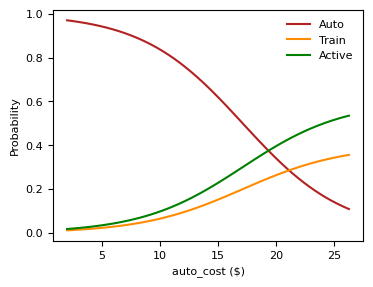

In [ ]:
data1_prb_lg = convert(data1_prb)
ls1_prb = mnl.predict(data1_prb_lg).reshape(len(data1_prb_lg)//3, 3)
ls1_grd = mnl.params[11] * ls1_prb[:, alt] * (1-ls1_prb[:, alt])

# Plot probabilities
# plt.plot(data1_prb[var], ls1_prb[:, alt], color='dimgrey')
# plt.xlabel(f'{var}')
# plt.ylabel('Probability')
# plt.show()

# Plot probability derivatives
# plt.plot(data1_prb[var], ls1_grd, color='dimgrey')
# plt.xlabel(f'{var}')
# plt.ylabel('Probability derivative')
# plt.show()

# Plot substitution patterns
ls_color = ['firebrick', 'darkorange', 'green', 'mediumblue']
# plt.axvline(data1.iloc[train_size, num_var], ls='--', color='darkgray')
for a in range(3):
    plt.plot(data1_prb[var], ls1_prb[:, a], color=ls_color[a], label=ls_alt[a])
plt.legend(frameon=False)
plt.xlabel(f'{var} ($)')
plt.ylabel('Probability')
plt.show()

In [ ]:
data1_reg = data1_test.copy()
data1_reg = data1_reg.loc[data1_reg.index.repeat(2)]
data1_reg.iloc[np.arange(1, len(data1_reg), 2), num_var] += (upper1 - lower1) / 50

data1_reg_lg = convert(data1_reg)
ls1_reg = mnl.predict(data1_reg_lg).reshape(len(data1_reg_lg)//3, 3)[:, alt]

In [ ]:
def cal_reg(ls_reg):
    eps = 1e-4
    diff = np.subtract(ls_reg[::2], ls_reg[1::2])
    diff_st = [(d > eps).astype(int) for d in diff]
    diff_wk = [(d > -eps).astype(int) for d in diff]
    reg_st = sum(diff_st) / len(diff_st)
    reg_wk = sum(diff_wk) / len(diff_wk)
    print(f'Strong regularity = {reg_st:.4f}')
    print(f'Weak regularity = {reg_wk:.4f}')
    return reg_st, reg_wk

In [1]:
# reg_st, reg_wk = cal_reg(ls1_reg)

# Deep neural network (DNN)

## Model structure

In [ ]:
class DNN(nn.Module):
    'Class of DNNs'
    def __init__(self):
        super(DNN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

## Model training
We train each model 30 times and take the average results of 10 models for analysis.

In [ ]:
def cal_loss(model, X, y, regularizer, sum, lambd, criterion):
    'Function to regularize the loss function'
    'lambd is the weight of regularizer -> (1-lambd) is the weight of loss'
    'sum is an indicator of regularizing summation'
    loss = criterion(model(X), y)
    # Utility gradient regularizer
    if regularizer == 'util':
        utl = model(X)
        g_c = grad(utl[:, 0], X, ones_like(utl[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(utl[:, 1], X, ones_like(utl[:, 1]), create_graph=True)[0][:, 6:8]
        g_a = grad(utl[:, 2], X, ones_like(utl[:, 2]), create_graph=True)[0][:, 8]
    # Probability gradient regularizer
    elif regularizer == 'prob':
        prb = softmax(model(X), dim=1)
        g_c = grad(prb[:, 0], X, ones_like(prb[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(prb[:, 1], X, ones_like(prb[:, 1]), create_graph=True)[0][:, 6:8]
        g_a = grad(prb[:, 2], X, ones_like(prb[:, 2]), create_graph=True)[0][:, 8]
    # Loss gradient regularizer
    elif regularizer == 'loss':
        log_prb = log(softmax(model(X), dim=1))
        g_c = grad(log_prb[:, 0]*(y==0), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(log_prb[:, 1]*(y==1), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 6:8]
        g_a = grad(log_prb[:, 2]*(y==2), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 8]
    else:
        return loss
    # Compute the regularizer
    if sum:
        g_c[g_c < 0] = 0
        g_t[g_t < 0] = 0
        g_a[g_a < 0] = 0
        reg = g_c.sum() + g_t.sum() + g_a.sum()
    else:
        reg = pow(g_c, 2).sum() + pow(g_t, 2).sum() + pow(g_a, 2).sum()
    return loss + lambd * reg

In [ ]:
def train_loop(model, regularizer, sum, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for batch, (X, y) in enumerate(train_loader):
        loss = cal_loss(model, X, y, regularizer, sum, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def test(model, criterion):
    'Function for DNN testing'
    # For loss, accuracy, and market share (testing set) calculation
    for X, y in test_loader:
        pred = model(X)
        loss = criterion(pred, y).item()
        cor = (pred.argmax(1) == y).float().sum()
        share_test = softmax(pred, dim=1).detach().numpy()
        p = softmax(pred, dim=1)
    loss /= len(test_loader)
    acc = cor / len(test_loader.dataset)
    # For market share (training set) calculation
    for X, _ in share_loader:
        share_train = softmax(model(X), dim=1).detach().numpy()
    # For probability and gradient calculation
    for X, _ in prb_loader:
        p = softmax(model(X), dim=1)
        prb = p.detach().numpy()
        grd = grad(p[:, alt], X, ones_like(p[:, alt]), create_graph=True)[0][:, num_var].detach().numpy()
    # For regularity calculation
    for X, _ in reg_loader:
        reg = softmax(model(X), dim=1)[:, alt].detach().numpy()
    return loss, acc, share_train, share_test, prb, grd, reg

In [ ]:
def train_DNN(regularizer, sum, lambd):
    'Function for DNN training (10 models * 30 epochs)'
    ls_loss, ls_acc, ls_share_ts, ls_share_tr, ls_prb, ls_grd, ls_reg = [[] for i in range(7)]
    for m in range(10):
        manual_seed(m)
        model = DNN()
        optimizer = optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        for i in range(30):
            train_loop(model, regularizer, sum, lambd, optimizer, criterion)
        loss, acc, share_train, share_test, prb, grd, reg = test(model, criterion)
        [x.append(y) for x, y in zip([ls_loss, ls_acc, ls_share_ts, ls_share_tr, ls_prb,
                                      ls_grd], [loss, acc, share_train, share_test, prb, grd])]
        ls_reg.extend(reg)
        print(f'Model {m+1:<2}: {loss:.4f}, {acc*100:.1f}%')
    return ls_loss, ls_acc, ls_share_tr, ls_share_ts, np.array(ls_prb), ls_grd, ls_reg

## Functions for analysis
We evaluate the models by:
- test losses and accuracies,
- strong and weak regularities.

In [ ]:
def dnn_agg(ls_loss, ls_acc):
    'Function to analyze aggregate DNN performance'
    mean_loss, mean_acc = np.mean(ls_loss), np.mean(ls_acc)
    ll = -mean_loss * (size - train_size)
    print(f'Mean test log-likelihood = {ll:.1f}')
    print(f'Mean test accuracy = {mean_acc*100:.1f}%')
    agg_ll, agg_acc = ll, mean_acc
    # Plot the histogram of test accuracies
    # plt.hist(ls_acc, bins=25, range=(.4, .9), weights=np.ones(len(ls_acc))/len(ls_acc), color='mediumblue')
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))
    # plt.xlabel('Test accuracy')
    # plt.ylabel('Percentage of all trials')
    # plt.show()
    return agg_ll, agg_acc

In [ ]:
def dnn_share(ls_share):
    'Function to analyze DNN market shares of modes'
    share = [sum(s)/len(s) for s in ls_share]
    avg_share = np.mean(share, 0) * 100
    std_share = np.std(share, 0) * 100
    df_avg = pd.DataFrame(avg_share).round(decimals=1)
    df_std = pd.DataFrame(std_share).round(decimals=1)
    df = df_avg.astype(str).add('% (').add(df_std.astype(str)).add('%)')
    df.columns = ['Share']
    df.insert(0, 'Mode', ls_alt)
    display(df)

In [ ]:
def dnn_sub(ls_prb, ls_grd):
    'Function to analyze DNN prabilities, probability derivatives, and substitution patterns'
    # Plot probabilities
    # for p in ls_prb[:, :, alt]:
    #     plt.plot(data1_prb[var], p, color='dimgrey', alpha=.15)
    # plt.plot(data1_prb[var], np.mean(ls_prb[:, :, alt], axis=0), color='dimgrey')
    # plt.xlabel(f'{var}')
    # plt.ylabel('Probability')
    # plt.show()
    # Plot probability derivatives
    # for p in ls_grd:
    #     plt.plot(data1_prb[var], p, color='dimgrey', alpha=.15)
    # plt.plot(data1_prb[var], np.mean(ls_grd, axis=0), color='dimgrey')
    # plt.xlabel(f'{var}')
    # plt.ylabel('Probability derivative')
    # plt.show()
    # Plot substitution patterns
    # plt.axvline(data1.iloc[train_size, num_var], ls='--', color='darkgray')
    for a in range(3):
        for p in ls_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=ls_color[a], alpha=.15)
        plt.plot(data1_prb[var], np.mean(ls_prb[:, :, a], axis=0), color=ls_color[a], label=ls_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    plt.show()

In [ ]:
def comparison(lambdas, agg_ll, agg_acc, ls_st, ls_wk):
    'Function to compare DNN models'
    if len(lambdas) == 1:
        return
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()
    # Plot test log-likelihoods
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='x', color=ls_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood')
    # Plot test accuracies
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='x', color=ls_color[1], label='Accuracy')
    ax2.set_ylabel('Test accuracy & Regularity')
    # Plot regularities
    ax2.plot(np.log10(lambdas), ls_st, linestyle='dashed', marker='x', color=ls_color[2], label='Strong regularity')
    ax2.plot(np.log10(lambdas), ls_wk, linestyle='dashed', marker='x', color=ls_color[3], label='Weak regularity')
    # fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax1.transAxes, frameon=False)

In [ ]:
def result(regularizer, lambdas=[0], sum=True):
    'Function to display all DNN results'
    agg_loss, agg_acc, ls_st, ls_wk = [[] for i in range(4)]
    for lambd in lambdas:
        print('Penalty =', lambd)
        # Individual losses and accuracies
        print('-'*30, '\nTest losses and accuracies:')
        ls_loss, ls_acc, ls_share_tr, ls_share_ts, ls_prb, ls_grd, ls_reg = train_DNN(regularizer, sum, lambd)
        # Mean loss and accuracy
        print('-'*30)
        [x.append(y) for x, y in zip([agg_loss, agg_acc], dnn_agg(ls_loss, ls_acc))]
        # Market shares
        print('-'*30, '\nTraining set:')
        dnn_share(ls_share_tr)
        print('-'*30, '\nTesting set:')
        dnn_share(ls_share_ts)
        # Regularities
        print('-'*30)
        reg_st, reg_wk = cal_reg(ls_reg)
        # Substitution patterns
        print('-'*30)
        dnn_sub(ls_prb, ls_grd)
        [x.append(y) for x, y in zip([ls_st, ls_wk], [reg_st, reg_wk])]
    comparison(lambdas, agg_loss, agg_acc, ls_st, ls_wk)

## Results

### Without regularization

Penalty = 0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7729, 70.7%
Model 2 : 0.7328, 71.0%
Model 3 : 0.7178, 71.3%
Model 4 : 0.6999, 72.7%
Model 5 : 0.7422, 71.3%
Model 6 : 0.7659, 70.0%
Model 7 : 0.7562, 71.0%
Model 8 : 0.7330, 69.7%
Model 9 : 0.7321, 72.0%
Model 10: 0.7348, 74.0%
------------------------------
Mean test log-likelihood = -221.6
Mean test accuracy = 71.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.8% (3.2%)
1,Train,12.2% (1.1%)
2,Active,17.9% (2.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (3.5%)
1,Train,12.2% (1.1%)
2,Active,19.9% (2.8%)


------------------------------
Strong regularity = 0.4850
Weak regularity = 0.5503
------------------------------


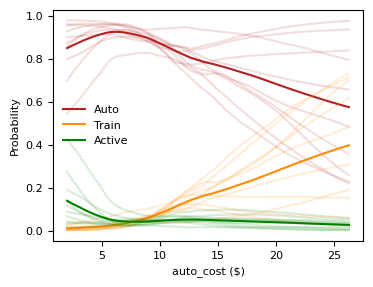

In [ ]:
result('none')

### Utility gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7113, 73.0%
Model 2 : 0.6966, 73.3%
Model 3 : 0.7298, 73.0%
Model 4 : 0.7075, 73.0%
Model 5 : 0.7079, 73.0%
Model 6 : 0.7515, 73.0%
Model 7 : 0.7103, 73.0%
Model 8 : 0.7206, 73.0%
Model 9 : 0.6946, 73.0%
Model 10: 0.7157, 73.0%
------------------------------
Mean test log-likelihood = -214.4
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.0% (1.2%)
1,Train,13.1% (1.4%)
2,Active,19.0% (0.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.6% (1.1%)
1,Train,13.1% (1.4%)
2,Active,19.3% (0.6%)


------------------------------
Strong regularity = 0.9693
Weak regularity = 0.9803
------------------------------


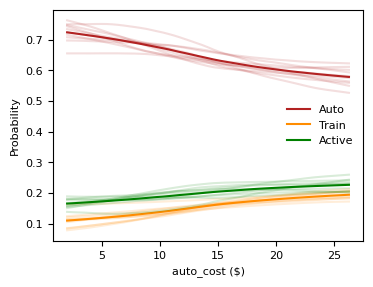

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6739, 74.0%
Model 2 : 0.6684, 73.3%
Model 3 : 0.6754, 74.3%
Model 4 : 0.6688, 75.7%
Model 5 : 0.6775, 73.3%
Model 6 : 0.6819, 73.3%
Model 7 : 0.6834, 74.0%
Model 8 : 0.6738, 72.7%
Model 9 : 0.6752, 74.7%
Model 10: 0.6863, 73.7%
------------------------------
Mean test log-likelihood = -202.9
Mean test accuracy = 73.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.3% (1.8%)
1,Train,11.0% (0.7%)
2,Active,18.6% (1.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.5% (1.8%)
1,Train,11.0% (0.7%)
2,Active,19.5% (1.4%)


------------------------------
Strong regularity = 0.9437
Weak regularity = 0.9517
------------------------------


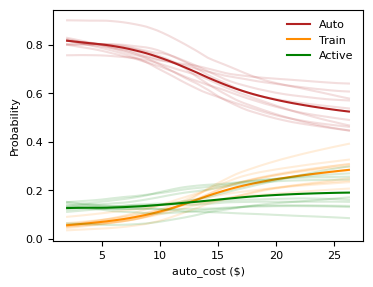

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6831, 74.0%
Model 2 : 0.6850, 72.3%
Model 3 : 0.6816, 72.3%
Model 4 : 0.6584, 76.3%
Model 5 : 0.6769, 76.3%
Model 6 : 0.6790, 74.3%
Model 7 : 0.6845, 74.0%
Model 8 : 0.7006, 71.0%
Model 9 : 0.6788, 75.0%
Model 10: 0.6800, 73.3%
------------------------------
Mean test log-likelihood = -204.2
Mean test accuracy = 73.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.3% (3.2%)
1,Train,12.0% (1.2%)
2,Active,18.7% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.8% (3.4%)
1,Train,11.7% (1.1%)
2,Active,20.5% (2.7%)


------------------------------
Strong regularity = 0.8860
Weak regularity = 0.9163
------------------------------


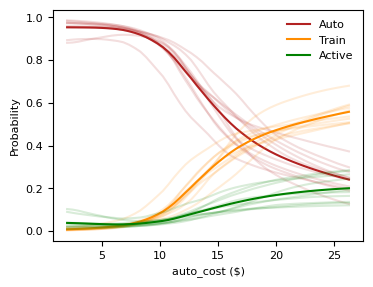

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7274, 71.7%
Model 2 : 0.7251, 71.7%
Model 3 : 0.7068, 72.3%
Model 4 : 0.6942, 72.7%
Model 5 : 0.7185, 74.7%
Model 6 : 0.7396, 71.7%
Model 7 : 0.7103, 73.0%
Model 8 : 0.7155, 72.3%
Model 9 : 0.7104, 74.0%
Model 10: 0.7224, 74.0%
------------------------------
Mean test log-likelihood = -215.1
Mean test accuracy = 72.8%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.0% (3.4%)
1,Train,11.8% (1.0%)
2,Active,18.1% (2.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.9% (3.7%)
1,Train,11.8% (1.0%)
2,Active,20.3% (2.9%)


------------------------------
Strong regularity = 0.7833
Weak regularity = 0.8233
------------------------------


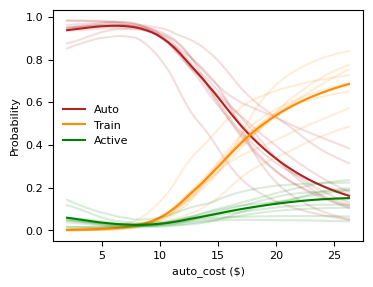

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7367, 71.3%
Model 2 : 0.7357, 72.0%
Model 3 : 0.7107, 73.3%
Model 4 : 0.6939, 73.0%
Model 5 : 0.7275, 72.7%
Model 6 : 0.7543, 72.0%
Model 7 : 0.7159, 72.7%
Model 8 : 0.7312, 72.3%
Model 9 : 0.7152, 74.0%
Model 10: 0.7291, 74.7%
------------------------------
Mean test log-likelihood = -217.5
Mean test accuracy = 72.8%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.1% (3.2%)
1,Train,12.0% (1.0%)
2,Active,17.9% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.9% (3.3%)
1,Train,12.0% (0.9%)
2,Active,20.1% (2.7%)


------------------------------
Strong regularity = 0.7497
Weak regularity = 0.7953
------------------------------


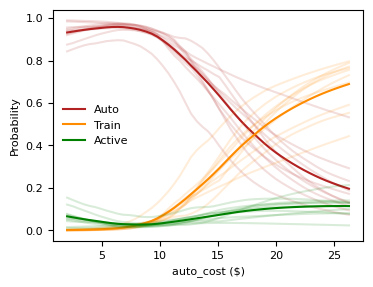

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7555, 70.7%
Model 2 : 0.7256, 72.3%
Model 3 : 0.7166, 72.3%
Model 4 : 0.7014, 72.3%
Model 5 : 0.7331, 73.3%
Model 6 : 0.7547, 71.3%
Model 7 : 0.7295, 71.3%
Model 8 : 0.7264, 70.0%
Model 9 : 0.7202, 74.0%
Model 10: 0.7225, 73.0%
------------------------------
Mean test log-likelihood = -218.6
Mean test accuracy = 72.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.8% (3.1%)
1,Train,12.1% (0.9%)
2,Active,18.1% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.8% (3.3%)
1,Train,12.1% (0.9%)
2,Active,20.0% (2.7%)


------------------------------
Strong regularity = 0.6970
Weak regularity = 0.7450
------------------------------


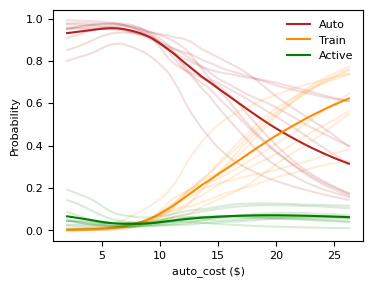

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7706, 70.7%
Model 2 : 0.7287, 72.0%
Model 3 : 0.7096, 71.3%
Model 4 : 0.6976, 73.0%
Model 5 : 0.7286, 72.7%
Model 6 : 0.7626, 71.0%
Model 7 : 0.7456, 71.7%
Model 8 : 0.7247, 70.7%
Model 9 : 0.7253, 73.0%
Model 10: 0.7273, 73.3%
------------------------------
Mean test log-likelihood = -219.6
Mean test accuracy = 71.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.8% (3.1%)
1,Train,12.2% (1.1%)
2,Active,18.0% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.9% (3.3%)
1,Train,12.1% (1.0%)
2,Active,19.9% (2.6%)


------------------------------
Strong regularity = 0.5660
Weak regularity = 0.6277
------------------------------


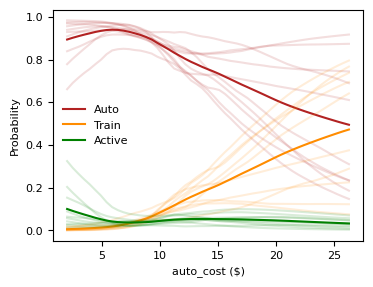

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7677, 70.7%
Model 2 : 0.7300, 72.3%
Model 3 : 0.7155, 71.7%
Model 4 : 0.7018, 72.3%
Model 5 : 0.7335, 72.3%
Model 6 : 0.7696, 70.0%
Model 7 : 0.7531, 71.0%
Model 8 : 0.7309, 70.7%
Model 9 : 0.7278, 72.3%
Model 10: 0.7382, 73.3%
------------------------------
Mean test log-likelihood = -221.0
Mean test accuracy = 71.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (3.1%)
1,Train,12.2% (1.0%)
2,Active,17.9% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.9% (3.3%)
1,Train,12.2% (1.0%)
2,Active,19.9% (2.6%)


------------------------------
Strong regularity = 0.4900
Weak regularity = 0.5593
------------------------------


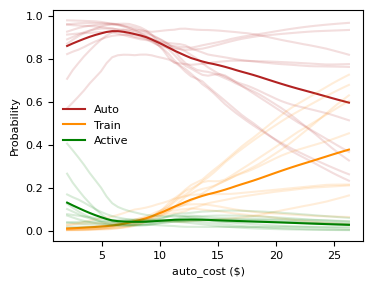

------------------------------ 
Model comparison:


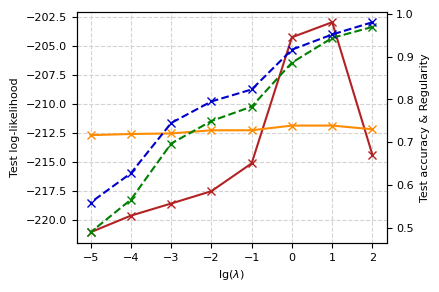

In [ ]:
# With sum
result('util', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7652, 73.0%
Model 2 : 0.7655, 73.0%
Model 3 : 0.7674, 73.0%
Model 4 : 0.7675, 73.0%
Model 5 : 0.7655, 73.0%
Model 6 : 0.7673, 73.0%
Model 7 : 0.7650, 73.0%
Model 8 : 0.7648, 73.0%
Model 9 : 0.7658, 73.0%
Model 10: 0.7670, 73.0%
------------------------------
Mean test log-likelihood = -229.8
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.1% (0.3%)
1,Train,13.0% (0.3%)
2,Active,18.9% (0.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (0.3%)
1,Train,13.0% (0.3%)
2,Active,18.9% (0.3%)


------------------------------
Strong regularity = 0.0000
Weak regularity = 0.9993
------------------------------


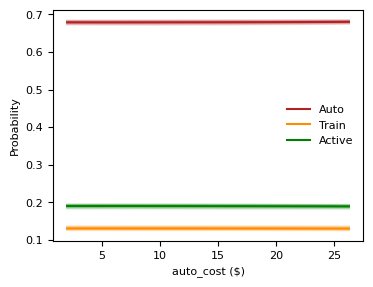

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7274, 73.0%
Model 2 : 0.7206, 73.0%
Model 3 : 0.7254, 73.0%
Model 4 : 0.7293, 73.0%
Model 5 : 0.7263, 73.0%
Model 6 : 0.7327, 73.0%
Model 7 : 0.7293, 73.0%
Model 8 : 0.7275, 73.0%
Model 9 : 0.7247, 73.0%
Model 10: 0.7252, 73.0%
------------------------------
Mean test log-likelihood = -218.1
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.1% (0.2%)
1,Train,12.1% (0.1%)
2,Active,18.8% (0.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.5% (0.3%)
1,Train,12.2% (0.1%)
2,Active,19.2% (0.2%)


------------------------------
Strong regularity = 0.0047
Weak regularity = 0.1273
------------------------------


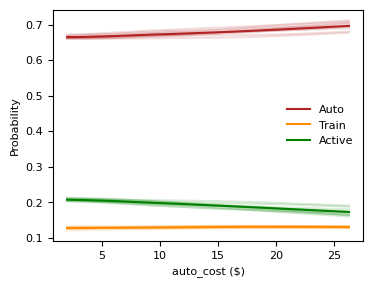

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6879, 75.0%
Model 2 : 0.6856, 74.7%
Model 3 : 0.6859, 75.0%
Model 4 : 0.6867, 74.0%
Model 5 : 0.6912, 74.0%
Model 6 : 0.6846, 74.3%
Model 7 : 0.6873, 74.3%
Model 8 : 0.6781, 74.3%
Model 9 : 0.6775, 74.7%
Model 10: 0.6908, 74.0%
------------------------------
Mean test log-likelihood = -205.7
Mean test accuracy = 74.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.0% (0.4%)
1,Train,11.5% (0.3%)
2,Active,18.5% (0.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.8% (0.4%)
1,Train,11.6% (0.4%)
2,Active,19.6% (0.5%)


------------------------------
Strong regularity = 0.0120
Weak regularity = 0.0537
------------------------------


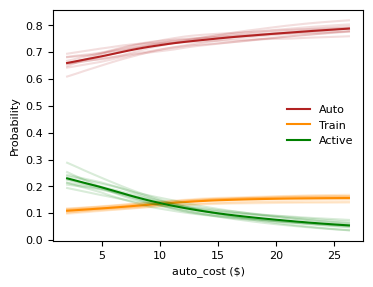

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6805, 74.3%
Model 2 : 0.6706, 74.0%
Model 3 : 0.6765, 73.3%
Model 4 : 0.6637, 74.3%
Model 5 : 0.6721, 74.0%
Model 6 : 0.6741, 74.0%
Model 7 : 0.6779, 73.0%
Model 8 : 0.6689, 74.3%
Model 9 : 0.6643, 73.7%
Model 10: 0.6825, 72.3%
------------------------------
Mean test log-likelihood = -201.9
Mean test accuracy = 73.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.7% (1.5%)
1,Train,11.6% (0.6%)
2,Active,18.7% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (1.5%)
1,Train,11.6% (0.5%)
2,Active,20.4% (1.2%)


------------------------------
Strong regularity = 0.2470
Weak regularity = 0.3023
------------------------------


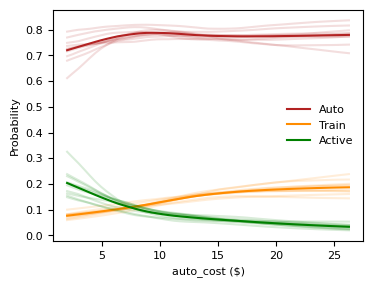

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6935, 72.0%
Model 2 : 0.6837, 71.7%
Model 3 : 0.6725, 73.7%
Model 4 : 0.6684, 74.7%
Model 5 : 0.6756, 74.7%
Model 6 : 0.6977, 71.0%
Model 7 : 0.6817, 73.0%
Model 8 : 0.6925, 72.0%
Model 9 : 0.6730, 74.3%
Model 10: 0.6892, 75.0%
------------------------------
Mean test log-likelihood = -204.8
Mean test accuracy = 73.2%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.3% (3.1%)
1,Train,11.7% (0.9%)
2,Active,18.0% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.5% (3.3%)
1,Train,11.6% (0.9%)
2,Active,20.0% (2.6%)


------------------------------
Strong regularity = 0.4053
Weak regularity = 0.4583
------------------------------


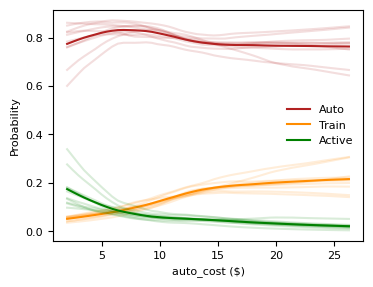

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7285, 70.3%
Model 2 : 0.7064, 71.7%
Model 3 : 0.6924, 72.3%
Model 4 : 0.6847, 74.0%
Model 5 : 0.6888, 74.0%
Model 6 : 0.7293, 70.0%
Model 7 : 0.7043, 70.7%
Model 8 : 0.7138, 71.3%
Model 9 : 0.6953, 74.3%
Model 10: 0.7125, 74.0%
------------------------------
Mean test log-likelihood = -211.7
Mean test accuracy = 72.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (3.3%)
1,Train,12.0% (1.2%)
2,Active,18.1% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (3.5%)
1,Train,11.8% (1.1%)
2,Active,20.2% (2.6%)


------------------------------
Strong regularity = 0.4577
Weak regularity = 0.5097
------------------------------


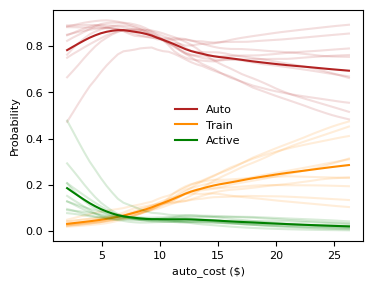

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7561, 70.0%
Model 2 : 0.7218, 71.7%
Model 3 : 0.7049, 71.0%
Model 4 : 0.6906, 73.3%
Model 5 : 0.7160, 72.7%
Model 6 : 0.7507, 70.3%
Model 7 : 0.7393, 71.3%
Model 8 : 0.7258, 70.3%
Model 9 : 0.7114, 72.7%
Model 10: 0.7253, 74.3%
------------------------------
Mean test log-likelihood = -217.3
Mean test accuracy = 71.8%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.0% (3.1%)
1,Train,12.3% (1.1%)
2,Active,17.8% (2.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.1% (3.3%)
1,Train,12.1% (1.1%)
2,Active,19.8% (2.7%)


------------------------------
Strong regularity = 0.4553
Weak regularity = 0.5153
------------------------------


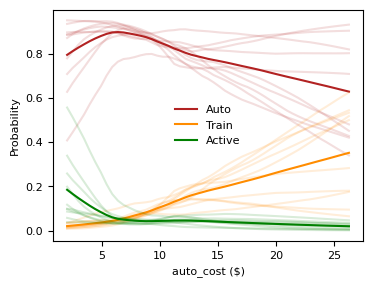

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7610, 71.0%
Model 2 : 0.7258, 71.3%
Model 3 : 0.7138, 70.7%
Model 4 : 0.6997, 72.3%
Model 5 : 0.7305, 72.0%
Model 6 : 0.7601, 69.7%
Model 7 : 0.7507, 70.7%
Model 8 : 0.7329, 70.0%
Model 9 : 0.7193, 72.0%
Model 10: 0.7266, 74.0%
------------------------------
Mean test log-likelihood = -219.6
Mean test accuracy = 71.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.7% (3.4%)
1,Train,12.3% (1.2%)
2,Active,18.0% (2.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.8% (3.6%)
1,Train,12.2% (1.1%)
2,Active,20.0% (2.9%)


------------------------------
Strong regularity = 0.4760
Weak regularity = 0.5383
------------------------------


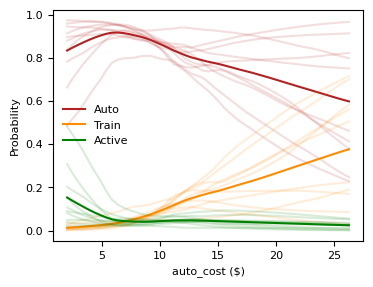

------------------------------ 
Model comparison:


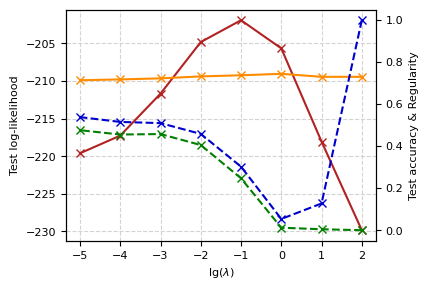

In [ ]:
# With norm
result('util', [np.power(10, i) for i in np.arange(2, -6, -1.0)], False)

### Probability gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7050, 73.0%
Model 2 : 0.6901, 73.0%
Model 3 : 0.7130, 73.0%
Model 4 : 0.7086, 73.0%
Model 5 : 0.6955, 73.0%
Model 6 : 0.7447, 73.0%
Model 7 : 0.6985, 73.0%
Model 8 : 0.7128, 73.0%
Model 9 : 0.6977, 73.0%
Model 10: 0.7244, 73.0%
------------------------------
Mean test log-likelihood = -212.7
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (0.9%)
1,Train,12.1% (0.8%)
2,Active,18.0% (0.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.5% (1.0%)
1,Train,12.2% (0.7%)
2,Active,18.3% (0.7%)


------------------------------
Strong regularity = 0.9990
Weak regularity = 0.9993
------------------------------


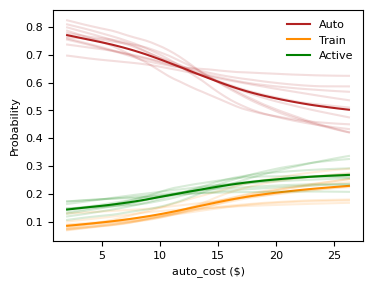

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6686, 75.7%
Model 2 : 0.6568, 74.0%
Model 3 : 0.6640, 74.3%
Model 4 : 0.6642, 75.0%
Model 5 : 0.6597, 74.7%
Model 6 : 0.6691, 73.7%
Model 7 : 0.6639, 75.3%
Model 8 : 0.6651, 74.0%
Model 9 : 0.6633, 75.7%
Model 10: 0.6697, 75.7%
------------------------------
Mean test log-likelihood = -199.3
Mean test accuracy = 74.8%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.9% (1.2%)
1,Train,11.6% (0.7%)
2,Active,17.5% (1.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.2% (1.3%)
1,Train,11.5% (0.7%)
2,Active,18.3% (1.4%)


------------------------------
Strong regularity = 0.9763
Weak regularity = 0.9990
------------------------------


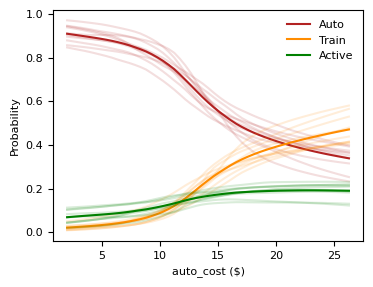

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6997, 70.3%
Model 2 : 0.7033, 71.3%
Model 3 : 0.6930, 73.7%
Model 4 : 0.6761, 76.0%
Model 5 : 0.6774, 74.7%
Model 6 : 0.6883, 75.0%
Model 7 : 0.6873, 73.7%
Model 8 : 0.6916, 72.7%
Model 9 : 0.6903, 76.3%
Model 10: 0.6965, 74.0%
------------------------------
Mean test log-likelihood = -207.1
Mean test accuracy = 73.8%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.3% (3.2%)
1,Train,12.3% (1.6%)
2,Active,18.4% (1.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.7% (3.1%)
1,Train,12.3% (1.5%)
2,Active,20.1% (1.9%)


------------------------------
Strong regularity = 0.9683
Weak regularity = 0.9997
------------------------------


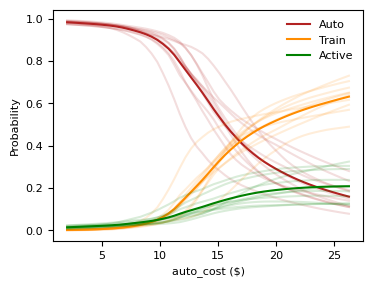

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7258, 71.7%
Model 2 : 0.7249, 71.3%
Model 3 : 0.7221, 72.7%
Model 4 : 0.6901, 73.0%
Model 5 : 0.7050, 74.7%
Model 6 : 0.7401, 71.7%
Model 7 : 0.7148, 73.7%
Model 8 : 0.7127, 71.3%
Model 9 : 0.7081, 73.7%
Model 10: 0.7251, 73.3%
------------------------------
Mean test log-likelihood = -215.1
Mean test accuracy = 72.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.3% (3.0%)
1,Train,12.5% (1.0%)
2,Active,18.3% (2.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.3% (3.1%)
1,Train,12.5% (0.9%)
2,Active,20.2% (2.4%)


------------------------------
Strong regularity = 0.9537
Weak regularity = 0.9910
------------------------------


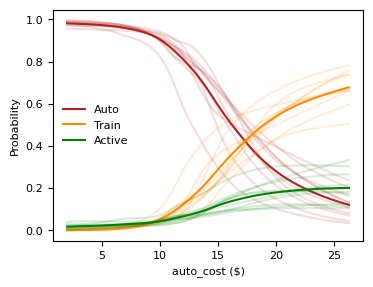

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7373, 72.7%
Model 2 : 0.7254, 71.3%
Model 3 : 0.7128, 72.7%
Model 4 : 0.7000, 72.7%
Model 5 : 0.7269, 73.7%
Model 6 : 0.7620, 71.3%
Model 7 : 0.7165, 72.0%
Model 8 : 0.7190, 72.0%
Model 9 : 0.7209, 74.3%
Model 10: 0.7274, 74.3%
------------------------------
Mean test log-likelihood = -217.4
Mean test accuracy = 72.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.6% (3.0%)
1,Train,12.1% (0.9%)
2,Active,18.3% (2.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.4% (3.2%)
1,Train,12.3% (0.8%)
2,Active,20.2% (2.6%)


------------------------------
Strong regularity = 0.9053
Weak regularity = 0.9517
------------------------------


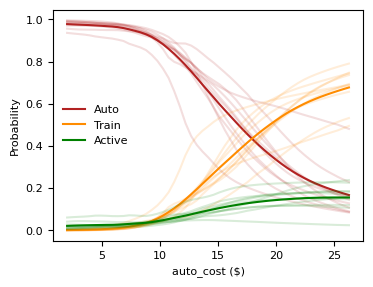

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7581, 71.0%
Model 2 : 0.7289, 72.0%
Model 3 : 0.7135, 72.0%
Model 4 : 0.7010, 72.0%
Model 5 : 0.7303, 72.3%
Model 6 : 0.7693, 70.7%
Model 7 : 0.7377, 71.7%
Model 8 : 0.7247, 70.3%
Model 9 : 0.7280, 74.0%
Model 10: 0.7450, 73.0%
------------------------------
Mean test log-likelihood = -220.1
Mean test accuracy = 71.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.7% (3.1%)
1,Train,12.1% (1.0%)
2,Active,18.2% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.8% (3.3%)
1,Train,12.1% (1.0%)
2,Active,20.1% (2.6%)


------------------------------
Strong regularity = 0.7000
Weak regularity = 0.7633
------------------------------


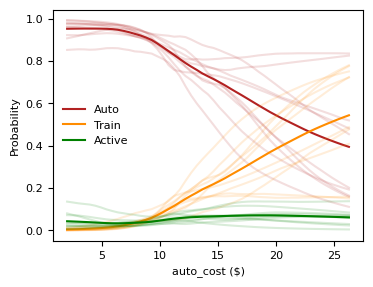

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7653, 71.7%
Model 2 : 0.7322, 71.3%
Model 3 : 0.7154, 71.7%
Model 4 : 0.7062, 72.7%
Model 5 : 0.7335, 72.3%
Model 6 : 0.7757, 69.7%
Model 7 : 0.7515, 71.0%
Model 8 : 0.7302, 70.0%
Model 9 : 0.7325, 72.0%
Model 10: 0.7345, 73.0%
------------------------------
Mean test log-likelihood = -221.3
Mean test accuracy = 71.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.8% (3.1%)
1,Train,12.2% (1.0%)
2,Active,18.0% (2.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (3.4%)
1,Train,12.1% (1.0%)
2,Active,19.9% (2.7%)


------------------------------
Strong regularity = 0.5167
Weak regularity = 0.5810
------------------------------


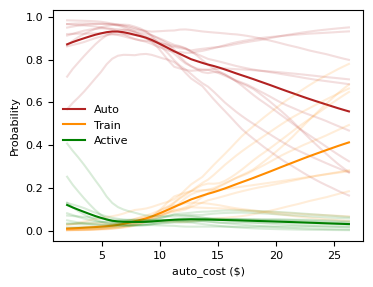

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7729, 70.3%
Model 2 : 0.7330, 71.7%
Model 3 : 0.7095, 71.3%
Model 4 : 0.6994, 72.7%
Model 5 : 0.7434, 72.3%
Model 6 : 0.7710, 70.0%
Model 7 : 0.7528, 71.0%
Model 8 : 0.7272, 70.7%
Model 9 : 0.7335, 72.0%
Model 10: 0.7293, 73.3%
------------------------------
Mean test log-likelihood = -221.2
Mean test accuracy = 71.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (3.2%)
1,Train,12.2% (1.1%)
2,Active,18.0% (2.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (3.5%)
1,Train,12.1% (1.1%)
2,Active,19.9% (2.7%)


------------------------------
Strong regularity = 0.4863
Weak regularity = 0.5527
------------------------------


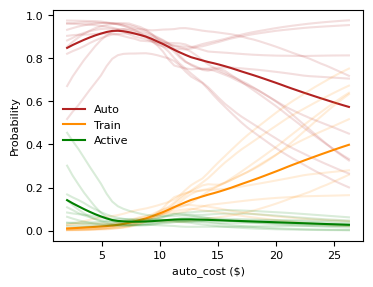

------------------------------ 
Model comparison:


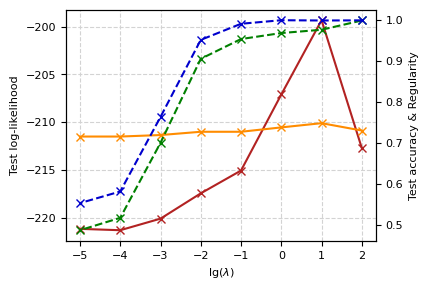

In [ ]:
# With sum
result('prob', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 1000.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7639, 73.0%
Model 2 : 0.7632, 73.0%
Model 3 : 0.7648, 73.0%
Model 4 : 0.7653, 73.0%
Model 5 : 0.7651, 73.0%
Model 6 : 0.7646, 73.0%
Model 7 : 0.7646, 73.0%
Model 8 : 0.7634, 73.0%
Model 9 : 0.7649, 73.0%
Model 10: 0.7654, 73.0%
------------------------------
Mean test log-likelihood = -229.4
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (0.3%)
1,Train,12.0% (0.2%)
2,Active,19.4% (0.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.7% (0.3%)
1,Train,12.0% (0.2%)
2,Active,19.4% (0.3%)


------------------------------
Strong regularity = 0.0007
Weak regularity = 0.9997
------------------------------


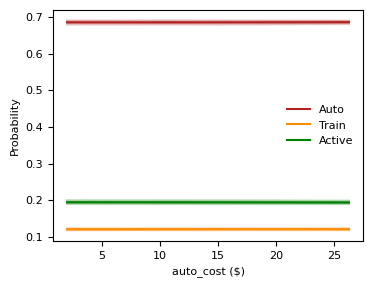

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7264, 73.0%
Model 2 : 0.7208, 73.0%
Model 3 : 0.7259, 73.0%
Model 4 : 0.7236, 73.0%
Model 5 : 0.7272, 73.0%
Model 6 : 0.7342, 73.0%
Model 7 : 0.7255, 73.0%
Model 8 : 0.7233, 73.0%
Model 9 : 0.7239, 73.0%
Model 10: 0.7265, 73.0%
------------------------------
Mean test log-likelihood = -217.7
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.4% (0.4%)
1,Train,11.1% (0.1%)
2,Active,18.5% (0.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.0% (0.4%)
1,Train,11.1% (0.1%)
2,Active,18.8% (0.3%)


------------------------------
Strong regularity = 0.0857
Weak regularity = 0.7617
------------------------------


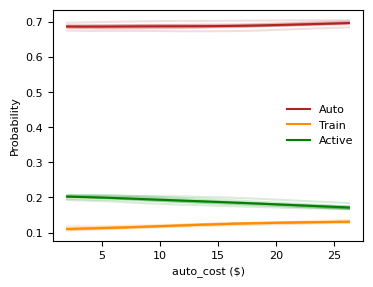

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6775, 73.3%
Model 2 : 0.6796, 73.3%
Model 3 : 0.6830, 73.0%
Model 4 : 0.6802, 73.0%
Model 5 : 0.6861, 73.0%
Model 6 : 0.6831, 73.0%
Model 7 : 0.6821, 73.0%
Model 8 : 0.6771, 73.3%
Model 9 : 0.6805, 73.0%
Model 10: 0.6857, 73.7%
------------------------------
Mean test log-likelihood = -204.4
Mean test accuracy = 73.2%
------------------------------ 
Training set:


,Mode,Share
0,Auto,71.5% (0.6%)
1,Train,10.7% (0.3%)
2,Active,17.8% (0.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.8% (0.6%)
1,Train,10.6% (0.3%)
2,Active,18.6% (0.6%)


------------------------------
Strong regularity = 0.3490
Weak regularity = 0.5600
------------------------------


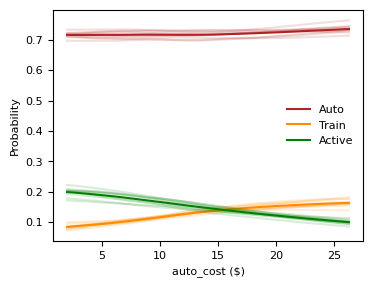

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6703, 75.0%
Model 2 : 0.6644, 74.7%
Model 3 : 0.6720, 74.0%
Model 4 : 0.6621, 74.3%
Model 5 : 0.6717, 74.0%
Model 6 : 0.6664, 74.0%
Model 7 : 0.6717, 75.0%
Model 8 : 0.6654, 73.7%
Model 9 : 0.6646, 74.7%
Model 10: 0.6731, 73.3%
------------------------------
Mean test log-likelihood = -200.5
Mean test accuracy = 74.3%
------------------------------ 
Training set:


,Mode,Share
0,Auto,72.1% (1.2%)
1,Train,10.5% (0.5%)
2,Active,17.5% (1.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,71.2% (1.3%)
1,Train,10.2% (0.5%)
2,Active,18.6% (1.5%)


------------------------------
Strong regularity = 0.4820
Weak regularity = 0.5693
------------------------------


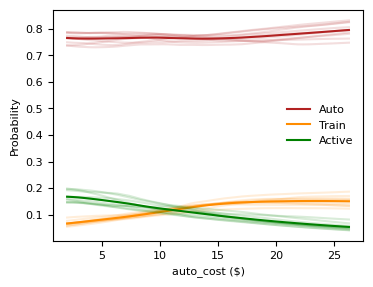

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6846, 74.0%
Model 2 : 0.6748, 74.0%
Model 3 : 0.6685, 73.3%
Model 4 : 0.6681, 74.3%
Model 5 : 0.6733, 74.7%
Model 6 : 0.6903, 72.7%
Model 7 : 0.6690, 74.7%
Model 8 : 0.6780, 72.7%
Model 9 : 0.6722, 74.3%
Model 10: 0.6891, 74.0%
------------------------------
Mean test log-likelihood = -203.0
Mean test accuracy = 73.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,71.8% (2.5%)
1,Train,10.2% (0.8%)
2,Active,18.1% (2.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (2.7%)
1,Train,9.9% (0.8%)
2,Active,19.7% (2.4%)


------------------------------
Strong regularity = 0.4820
Weak regularity = 0.5237
------------------------------


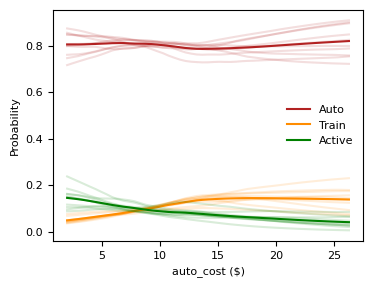

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7103, 71.0%
Model 2 : 0.6944, 71.3%
Model 3 : 0.6805, 74.0%
Model 4 : 0.6765, 74.7%
Model 5 : 0.6833, 74.3%
Model 6 : 0.7196, 69.3%
Model 7 : 0.6911, 72.0%
Model 8 : 0.6973, 71.3%
Model 9 : 0.6904, 74.7%
Model 10: 0.7062, 74.7%
------------------------------
Mean test log-likelihood = -208.5
Mean test accuracy = 72.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.6% (3.3%)
1,Train,10.7% (1.2%)
2,Active,18.6% (2.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.0% (3.5%)
1,Train,10.4% (1.1%)
2,Active,20.6% (3.1%)


------------------------------
Strong regularity = 0.4880
Weak regularity = 0.5277
------------------------------


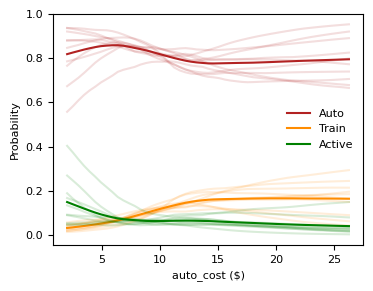

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7378, 70.7%
Model 2 : 0.7151, 72.7%
Model 3 : 0.6981, 72.0%
Model 4 : 0.6893, 73.3%
Model 5 : 0.7139, 73.7%
Model 6 : 0.7408, 70.7%
Model 7 : 0.7272, 70.7%
Model 8 : 0.7125, 71.3%
Model 9 : 0.7078, 72.7%
Model 10: 0.7224, 73.3%
------------------------------
Mean test log-likelihood = -214.9
Mean test accuracy = 72.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.4% (3.1%)
1,Train,11.4% (1.1%)
2,Active,18.3% (2.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.6% (3.3%)
1,Train,11.2% (1.0%)
2,Active,20.2% (2.8%)


------------------------------
Strong regularity = 0.4550
Weak regularity = 0.5120
------------------------------


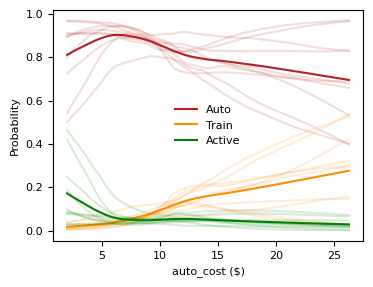

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7675, 71.3%
Model 2 : 0.7338, 71.0%
Model 3 : 0.7110, 72.0%
Model 4 : 0.6993, 72.7%
Model 5 : 0.7370, 72.0%
Model 6 : 0.7628, 70.0%
Model 7 : 0.7550, 71.7%
Model 8 : 0.7316, 70.0%
Model 9 : 0.7239, 72.0%
Model 10: 0.7277, 73.7%
------------------------------
Mean test log-likelihood = -220.5
Mean test accuracy = 71.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (3.3%)
1,Train,12.0% (1.2%)
2,Active,18.0% (2.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.1% (3.6%)
1,Train,12.0% (1.1%)
2,Active,20.0% (2.8%)


------------------------------
Strong regularity = 0.4810
Weak regularity = 0.5443
------------------------------


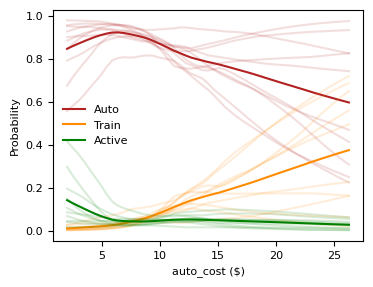

------------------------------ 
Model comparison:


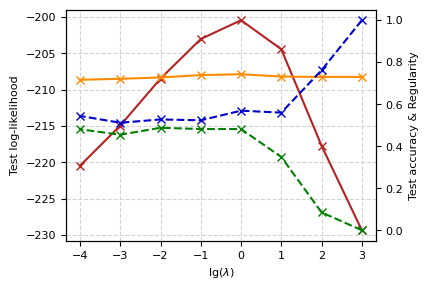

In [ ]:
# With norm
result('prob', [np.power(10, i) for i in np.arange(3, -5, -1.0)], False)

### Loss gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7160, 73.0%
Model 2 : 0.7234, 73.0%
Model 3 : 0.7239, 73.0%
Model 4 : 0.7232, 73.0%
Model 5 : 0.7154, 73.0%
Model 6 : 0.7750, 73.0%
Model 7 : 0.7074, 73.0%
Model 8 : 0.7063, 73.0%
Model 9 : 0.7111, 73.0%
Model 10: 0.7604, 73.0%
------------------------------
Mean test log-likelihood = -217.9
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,67.7% (3.3%)
1,Train,12.9% (1.9%)
2,Active,19.4% (2.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.4% (3.1%)
1,Train,13.0% (1.8%)
2,Active,19.6% (2.2%)


------------------------------
Strong regularity = 0.9990
Weak regularity = 0.9997
------------------------------


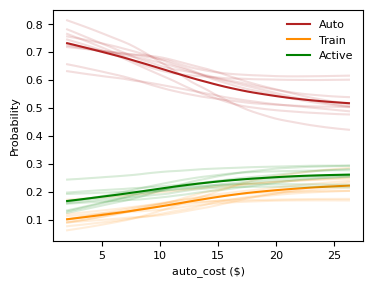

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6955, 75.7%
Model 2 : 0.6602, 74.7%
Model 3 : 0.6710, 75.7%
Model 4 : 0.6763, 74.0%
Model 5 : 0.7029, 74.7%
Model 6 : 0.6851, 73.0%
Model 7 : 0.6864, 73.0%
Model 8 : 0.6693, 73.0%
Model 9 : 0.6800, 73.0%
Model 10: 0.6709, 73.3%
------------------------------
Mean test log-likelihood = -203.9
Mean test accuracy = 74.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.0% (0.7%)
1,Train,11.5% (0.9%)
2,Active,18.5% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.2% (0.7%)
1,Train,11.6% (0.8%)
2,Active,19.2% (1.1%)


------------------------------
Strong regularity = 0.9830
Weak regularity = 0.9993
------------------------------


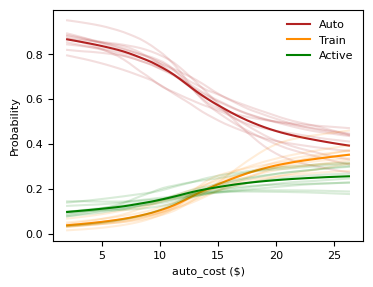

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6936, 72.7%
Model 2 : 0.6810, 75.3%
Model 3 : 0.6683, 76.7%
Model 4 : 0.6661, 75.0%
Model 5 : 0.6767, 76.0%
Model 6 : 0.7083, 74.7%
Model 7 : 0.6880, 74.0%
Model 8 : 0.6866, 74.3%
Model 9 : 0.6898, 75.0%
Model 10: 0.6884, 73.3%
------------------------------
Mean test log-likelihood = -205.4
Mean test accuracy = 74.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.8% (1.5%)
1,Train,12.5% (1.8%)
2,Active,17.7% (1.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.5% (1.4%)
1,Train,12.4% (1.7%)
2,Active,19.2% (1.6%)


------------------------------
Strong regularity = 0.9647
Weak regularity = 0.9967
------------------------------


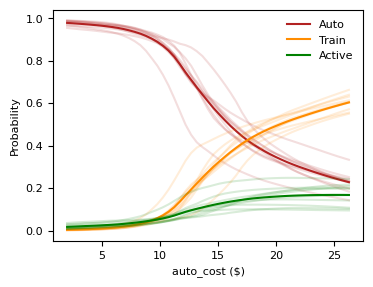

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7292, 71.7%
Model 2 : 0.7261, 72.0%
Model 3 : 0.7288, 72.7%
Model 4 : 0.6923, 72.7%
Model 5 : 0.7029, 73.7%
Model 6 : 0.7425, 72.3%
Model 7 : 0.7117, 73.0%
Model 8 : 0.7287, 71.0%
Model 9 : 0.7096, 73.7%
Model 10: 0.7191, 74.3%
------------------------------
Mean test log-likelihood = -215.7
Mean test accuracy = 72.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (4.0%)
1,Train,12.9% (1.6%)
2,Active,18.4% (2.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.9% (4.1%)
1,Train,12.8% (1.5%)
2,Active,20.3% (2.9%)


------------------------------
Strong regularity = 0.9480
Weak regularity = 0.9853
------------------------------


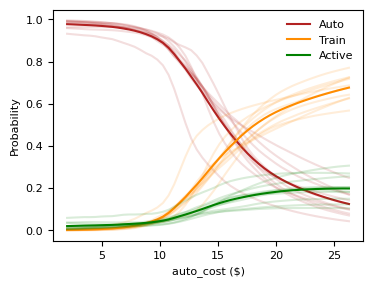

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7329, 72.0%
Model 2 : 0.7198, 70.7%
Model 3 : 0.7124, 72.0%
Model 4 : 0.6998, 72.0%
Model 5 : 0.7182, 74.3%
Model 6 : 0.7568, 71.7%
Model 7 : 0.7228, 72.3%
Model 8 : 0.7181, 72.0%
Model 9 : 0.7142, 73.7%
Model 10: 0.7253, 74.7%
------------------------------
Mean test log-likelihood = -216.6
Mean test accuracy = 72.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (3.1%)
1,Train,12.2% (1.0%)
2,Active,17.9% (2.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.9% (3.3%)
1,Train,12.3% (1.0%)
2,Active,19.8% (2.6%)


------------------------------
Strong regularity = 0.8980
Weak regularity = 0.9423
------------------------------


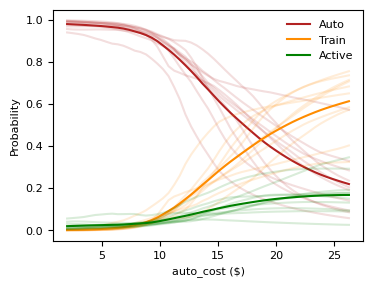

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7565, 70.7%
Model 2 : 0.7309, 72.0%
Model 3 : 0.7120, 72.0%
Model 4 : 0.7026, 71.7%
Model 5 : 0.7305, 73.7%
Model 6 : 0.7658, 70.0%
Model 7 : 0.7386, 72.0%
Model 8 : 0.7252, 70.3%
Model 9 : 0.7253, 74.0%
Model 10: 0.7395, 73.0%
------------------------------
Mean test log-likelihood = -219.8
Mean test accuracy = 71.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (3.1%)
1,Train,12.1% (0.9%)
2,Active,18.0% (2.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.9% (3.4%)
1,Train,12.2% (0.9%)
2,Active,19.9% (2.7%)


------------------------------
Strong regularity = 0.7133
Weak regularity = 0.7713
------------------------------


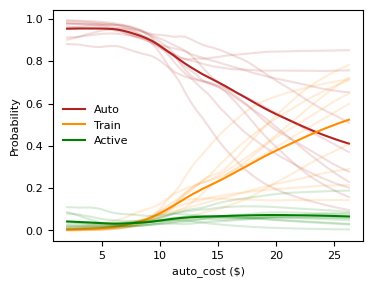

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7706, 70.7%
Model 2 : 0.7311, 71.3%
Model 3 : 0.7148, 71.7%
Model 4 : 0.6987, 72.3%
Model 5 : 0.7362, 72.7%
Model 6 : 0.7682, 71.0%
Model 7 : 0.7572, 71.0%
Model 8 : 0.7299, 70.7%
Model 9 : 0.7303, 72.0%
Model 10: 0.7359, 73.3%
------------------------------
Mean test log-likelihood = -221.2
Mean test accuracy = 71.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.8% (3.2%)
1,Train,12.3% (1.1%)
2,Active,17.9% (2.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (3.4%)
1,Train,12.2% (1.1%)
2,Active,19.8% (2.7%)


------------------------------
Strong regularity = 0.5150
Weak regularity = 0.5807
------------------------------


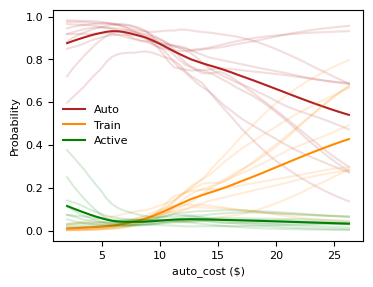

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7721, 70.7%
Model 2 : 0.7305, 72.3%
Model 3 : 0.7131, 71.7%
Model 4 : 0.6999, 72.7%
Model 5 : 0.7410, 72.7%
Model 6 : 0.7705, 70.0%
Model 7 : 0.7565, 71.3%
Model 8 : 0.7291, 70.7%
Model 9 : 0.7322, 72.0%
Model 10: 0.7318, 72.3%
------------------------------
Mean test log-likelihood = -221.3
Mean test accuracy = 71.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.0% (3.0%)
1,Train,12.1% (0.9%)
2,Active,17.9% (2.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (3.3%)
1,Train,12.1% (1.0%)
2,Active,19.9% (2.7%)


------------------------------
Strong regularity = 0.4880
Weak regularity = 0.5537
------------------------------


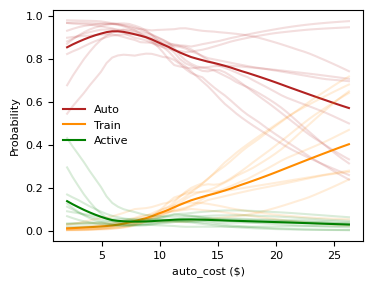

------------------------------ 
Model comparison:


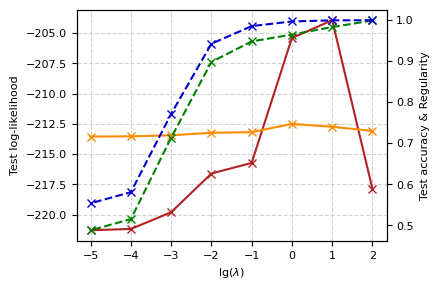

In [ ]:
# With sum
result('loss', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 1000.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.8126, 73.0%
Model 2 : 0.8211, 73.0%
Model 3 : 0.8302, 73.0%
Model 4 : 0.8817, 73.0%
Model 5 : 0.8229, 73.0%
Model 6 : 0.8993, 73.0%
Model 7 : 0.7895, 73.0%
Model 8 : 0.7912, 73.0%
Model 9 : 0.8082, 73.0%
Model 10: 0.8033, 73.0%
------------------------------
Mean test log-likelihood = -247.8
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,56.7% (4.5%)
1,Train,19.9% (2.7%)
2,Active,23.4% (2.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,56.7% (4.5%)
1,Train,19.9% (2.7%)
2,Active,23.4% (2.0%)


------------------------------
Strong regularity = 0.0000
Weak regularity = 0.9997
------------------------------


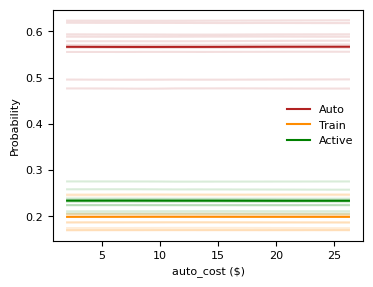

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7566, 73.0%
Model 2 : 0.7520, 73.0%
Model 3 : 0.7596, 73.0%
Model 4 : 0.7582, 73.0%
Model 5 : 0.7571, 73.0%
Model 6 : 0.7612, 73.0%
Model 7 : 0.7579, 73.0%
Model 8 : 0.7555, 73.0%
Model 9 : 0.7603, 73.0%
Model 10: 0.7578, 73.0%
------------------------------
Mean test log-likelihood = -227.3
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.2% (0.5%)
1,Train,12.3% (0.3%)
2,Active,19.5% (0.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.1% (0.5%)
1,Train,12.3% (0.3%)
2,Active,19.6% (0.3%)


------------------------------
Strong regularity = 0.0237
Weak regularity = 0.9640
------------------------------


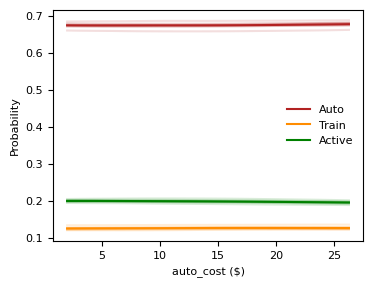

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7063, 73.0%
Model 2 : 0.7004, 73.0%
Model 3 : 0.7113, 73.0%
Model 4 : 0.7068, 73.0%
Model 5 : 0.7138, 73.0%
Model 6 : 0.7086, 73.0%
Model 7 : 0.7137, 73.0%
Model 8 : 0.7021, 73.0%
Model 9 : 0.7079, 73.0%
Model 10: 0.7067, 73.0%
------------------------------
Mean test log-likelihood = -212.3
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.6% (0.6%)
1,Train,12.0% (0.4%)
2,Active,18.4% (0.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.0% (0.5%)
1,Train,12.0% (0.4%)
2,Active,18.9% (0.3%)


------------------------------
Strong regularity = 0.3497
Weak regularity = 0.6547
------------------------------


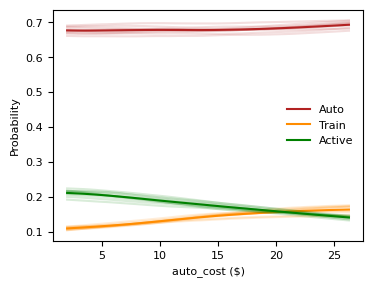

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6767, 73.7%
Model 2 : 0.6701, 73.7%
Model 3 : 0.6784, 74.0%
Model 4 : 0.6695, 74.0%
Model 5 : 0.6745, 74.3%
Model 6 : 0.6734, 74.0%
Model 7 : 0.6786, 74.3%
Model 8 : 0.6762, 74.0%
Model 9 : 0.6714, 73.7%
Model 10: 0.6791, 73.7%
------------------------------
Mean test log-likelihood = -202.4
Mean test accuracy = 73.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.7% (1.1%)
1,Train,11.7% (0.5%)
2,Active,17.6% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.9% (1.1%)
1,Train,11.5% (0.5%)
2,Active,18.5% (1.0%)


------------------------------
Strong regularity = 0.4137
Weak regularity = 0.4953
------------------------------


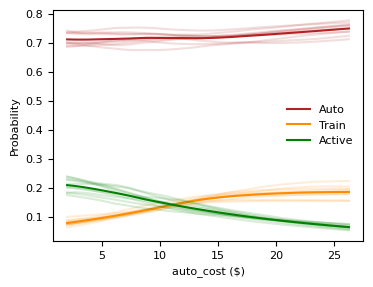

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6661, 74.3%
Model 2 : 0.6730, 74.0%
Model 3 : 0.6689, 74.7%
Model 4 : 0.6665, 74.3%
Model 5 : 0.6690, 74.0%
Model 6 : 0.6798, 73.0%
Model 7 : 0.6653, 74.7%
Model 8 : 0.6730, 73.7%
Model 9 : 0.6603, 75.0%
Model 10: 0.6778, 73.7%
------------------------------
Mean test log-likelihood = -201.0
Mean test accuracy = 74.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,71.5% (2.0%)
1,Train,11.6% (0.8%)
2,Active,17.0% (1.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (2.1%)
1,Train,11.3% (0.8%)
2,Active,18.3% (1.5%)


------------------------------
Strong regularity = 0.4340
Weak regularity = 0.4807
------------------------------


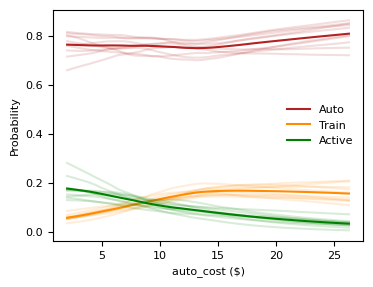

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6838, 74.7%
Model 2 : 0.6783, 74.0%
Model 3 : 0.6801, 75.3%
Model 4 : 0.6669, 74.3%
Model 5 : 0.6799, 75.0%
Model 6 : 0.7110, 71.7%
Model 7 : 0.6794, 73.7%
Model 8 : 0.6916, 73.0%
Model 9 : 0.6795, 75.0%
Model 10: 0.6835, 74.3%
------------------------------
Mean test log-likelihood = -205.0
Mean test accuracy = 74.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.2% (3.0%)
1,Train,12.3% (1.0%)
2,Active,17.5% (2.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.9% (3.2%)
1,Train,11.9% (0.9%)
2,Active,19.2% (2.8%)


------------------------------
Strong regularity = 0.4763
Weak regularity = 0.5077
------------------------------


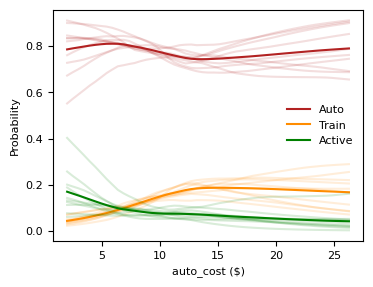

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7199, 71.0%
Model 2 : 0.6978, 72.0%
Model 3 : 0.6991, 73.0%
Model 4 : 0.6767, 73.3%
Model 5 : 0.7010, 74.3%
Model 6 : 0.7370, 70.0%
Model 7 : 0.7039, 74.0%
Model 8 : 0.7050, 71.3%
Model 9 : 0.6978, 73.7%
Model 10: 0.7139, 75.3%
------------------------------
Mean test log-likelihood = -211.6
Mean test accuracy = 72.8%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.6% (3.3%)
1,Train,12.6% (1.1%)
2,Active,17.9% (2.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,68.0% (3.5%)
1,Train,12.2% (1.0%)
2,Active,19.8% (3.0%)


------------------------------
Strong regularity = 0.4613
Weak regularity = 0.5057
------------------------------


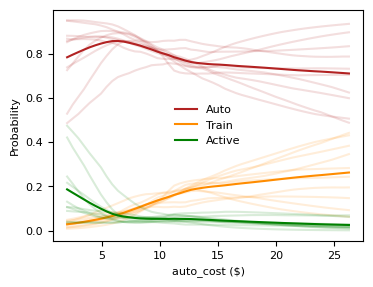

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7521, 71.0%
Model 2 : 0.7250, 71.3%
Model 3 : 0.7090, 71.7%
Model 4 : 0.6901, 72.0%
Model 5 : 0.7231, 72.7%
Model 6 : 0.7530, 70.7%
Model 7 : 0.7406, 70.7%
Model 8 : 0.7175, 70.3%
Model 9 : 0.7148, 72.3%
Model 10: 0.7238, 73.7%
------------------------------
Mean test log-likelihood = -217.5
Mean test accuracy = 71.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.5% (3.2%)
1,Train,12.4% (1.1%)
2,Active,18.0% (2.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.7% (3.5%)
1,Train,12.3% (1.1%)
2,Active,20.0% (2.8%)


------------------------------
Strong regularity = 0.4730
Weak regularity = 0.5307
------------------------------


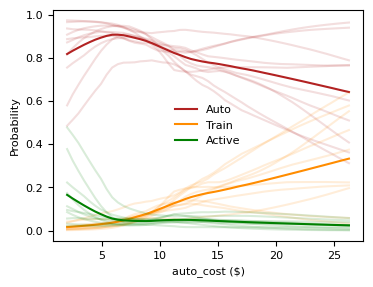

------------------------------ 
Model comparison:


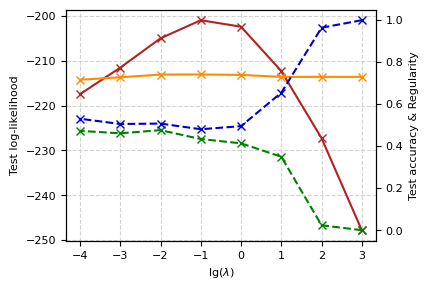

In [ ]:
# With norm
result('loss', [np.power(10, i) for i in np.arange(3, -5, -1.0)], False)